##### Experiment 1

Model Size: 850MB

Original Repo： Hugging Face.

Framework: Tensorflow.

NLP Task: Text Classification

Host Config:

```
cpu: 1
memory gb: 4
min instance: 0
max instance: 100
```
Entry point:
```
gunicorn -b :$PORT -w 1 app:app --timeout 1200
```

In [54]:
gcr_t5_base = 'https://zeroshot-t5-apnir7ajvq-nw.a.run.app/run-zerohot-t5'
sentence = '''
summarize: The US has passed the peak on new coronavirus cases, 
President Donald Trump said and predicted that some states would reopen this month. 
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, 
the highest for any country in the world. At the daily White House coronavirus briefing on Wednesday, 
Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. 
We will be the comeback kids, all of us, he said. We want to get our country back. 
The Trump administration has previously fixed May 1 as a possible date to reopen the worlds largest economy, 
but the president said some states may be able to return to normalcy earlier than that.
'''
data_t5_base = {
  "sentence": sentence,
    "model_name": "t5-base"
  }
import subprocess
import json
import requests

In [60]:
output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
access_token = "Bearer " + output[:-1]
headers = {'Authorization': access_token}
response = requests.post(gcr_t5_base, 
                         headers=headers, 
                         json=data_t5_base)
print(response.text)

{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}


In [62]:
import datetime
import time

tot_pred_time = datetime.timedelta(0)
execution_time = []

for i in range(10):
    print('Epoch: ', i)
    time_start = datetime.datetime.now()
    output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
    access_token = "Bearer " + output[:-1]
    headers = {'Authorization': access_token}
    response = requests.post(gcr_t5_base, 
                             headers=headers, 
                             json=data_t5_base)
    print(response.text)
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print("the time for making the API call is ", time_diff)
    tot_pred_time += time_diff
    execution_time.append(time_diff)
    time.sleep(20)
    
print("the average time for making an API call is ", tot_pred_time/10)

Epoch:  0
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:39.913815
Epoch:  1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:35.102430
Epoch:  2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:44.090304
Epoch:  3
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:41.059251
Epoch:  4
{ output:<pad> the US has over 637

In [63]:
import numpy as np
print(np.min(execution_time))
print(np.mean(execution_time))
print(np.max(execution_time))

0:00:33.375315
0:00:38.462307
0:00:44.122635


Fixed issue:
Epoch:  8
upstream connect error or disconnect/reset before headers. reset reason: connection termination

Sometimes observed memeory errors:


2021-05-04 12:22:06.522 BSTMemory limit of 4096M exceeded with 4733M used. Consider increasing the memory limit, see https://cloud.google.com/run/docs/configuring/memory-limits

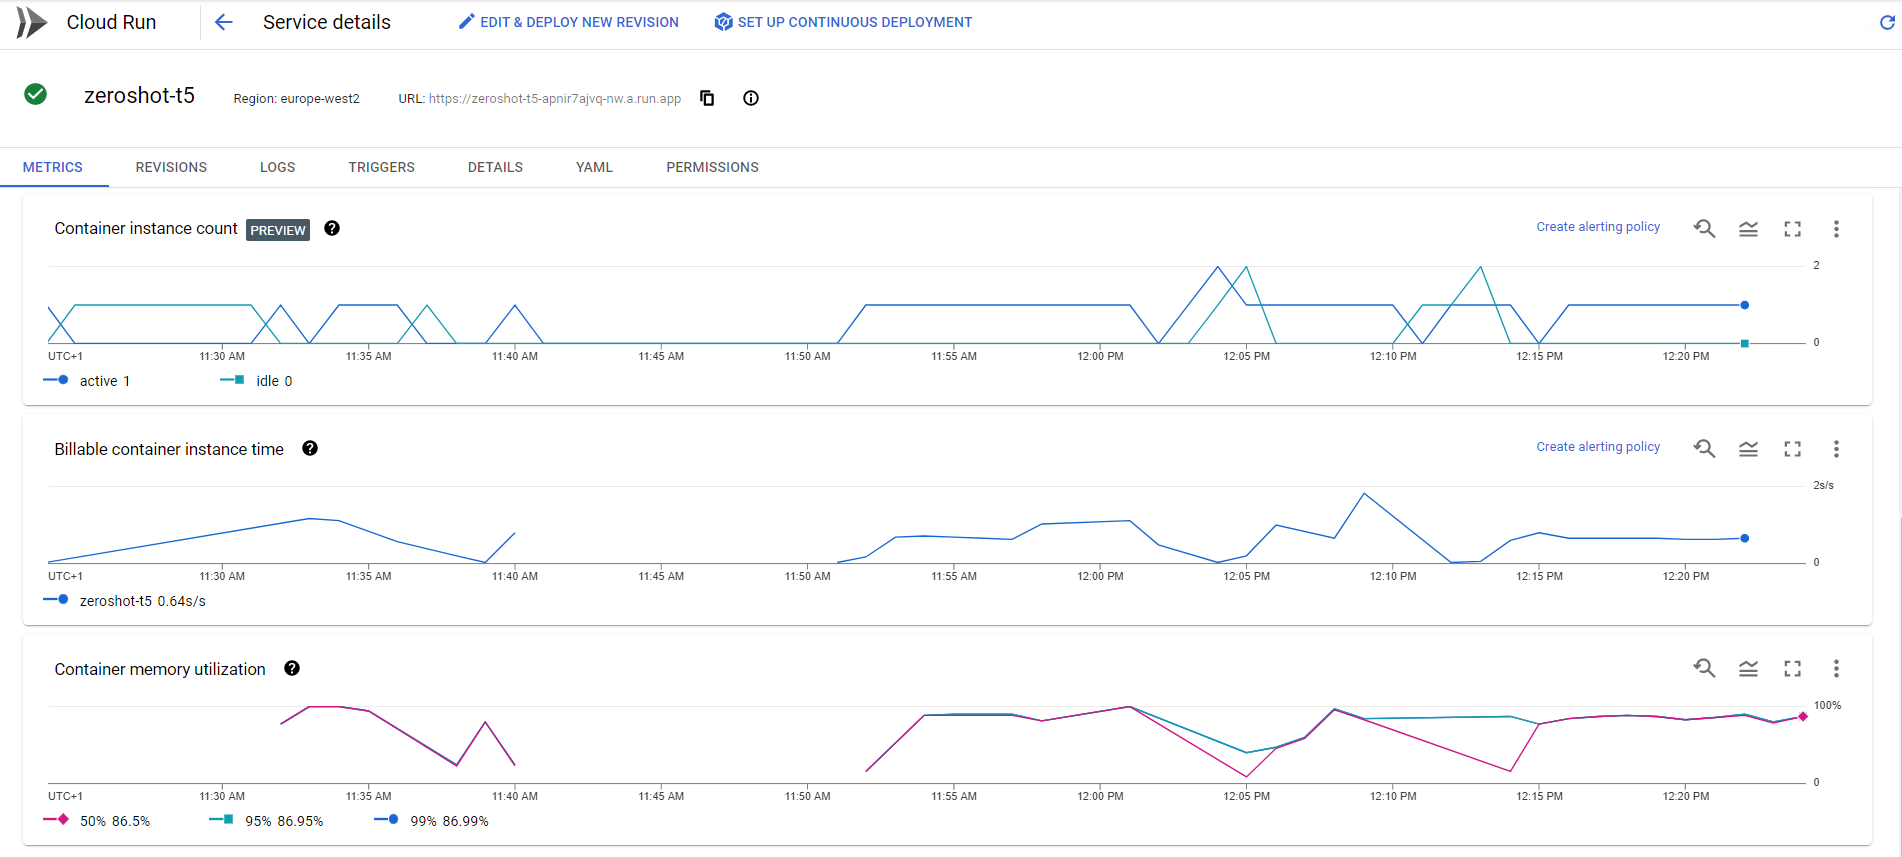

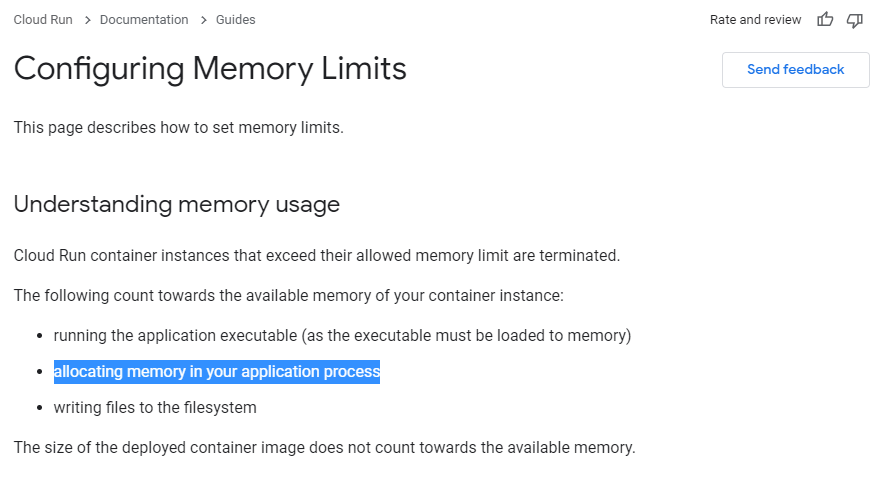

This may relate to using gunicorn. Gunicorn regularly spin out worker process for serving the requests.

https://cloud.google.com/run/docs/configuring/memory-limits

In [58]:
import time
import os                                                                       
import threading

def num_of_requests_processed_within_a_period(secs):
    num = 0
    stop_time = time.time() + secs
    while time.time() < stop_time:
        output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
        access_token = "Bearer " + output[:-1]
        headers = {'Authorization': access_token}
        response = requests.post(gcr_t5_base, 
                                 headers=headers, 
                                 json=data_t5_base)
        print(response.text)
        num += 1
    return num

In [61]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 2; tot number of requests processed in 20s are 2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new g

### Experiment 2

1 instance

Host Config:

```
cpu: 2
memory gb: 4
min instance: 0
max instance: 100
```

Entry point:
```
gunicorn -b :$PORT -w 1 app:app --timeout 1200
```

In [64]:
gcr_t5_base = 'https://zeroshot-t5-apnir7ajvq-nw.a.run.app/run-zerohot-t5'
sentence = '''
summarize: The US has passed the peak on new coronavirus cases, 
President Donald Trump said and predicted that some states would reopen this month. 
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, 
the highest for any country in the world. At the daily White House coronavirus briefing on Wednesday, 
Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. 
We will be the comeback kids, all of us, he said. We want to get our country back. 
The Trump administration has previously fixed May 1 as a possible date to reopen the worlds largest economy, 
but the president said some states may be able to return to normalcy earlier than that.
'''
data_t5_base = {
  "sentence": sentence,
    "model_name": "t5-base"
  }

In [70]:
output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
access_token = "Bearer " + output[:-1]
headers = {'Authorization': access_token}
response = requests.post(gcr_t5_base, 
                         headers=headers, 
                         json=data_t5_base)
print(response.text)

{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}


In [66]:
import datetime
import time

tot_pred_time = datetime.timedelta(0)
execution_time = []

for i in range(10):
    print('Epoch: ', i)
    time_start = datetime.datetime.now()
    output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
    access_token = "Bearer " + output[:-1]
    headers = {'Authorization': access_token}
    response = requests.post(gcr_t5_base, 
                             headers=headers, 
                             json=data_t5_base)
    print(response.text)
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print("the time for making the API call is ", time_diff)
    tot_pred_time += time_diff
    execution_time.append(time_diff)
    time.sleep(10)
    
print("the average time for making an API call is ", tot_pred_time/10)

Epoch:  0
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:20.657175
Epoch:  1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:22.067959
Epoch:  2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:27.184930
Epoch:  3
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:21.515000
Epoch:  4
{ output:<pad> the US has over 637

In [67]:
# Latency
import numpy as np
print(np.min(execution_time))
print(np.mean(execution_time))
print(np.max(execution_time))

0:00:20.254012
0:00:22.865828
0:00:27.707421


In [68]:
import time
import os                                                                       
import threading

def num_of_requests_processed_within_a_period(secs):
    num = 0
    stop_time = time.time() + secs
    while time.time() < stop_time:
        output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
        access_token = "Bearer " + output[:-1]
        headers = {'Authorization': access_token}
        response = requests.post(gcr_t5_base, 
                                 headers=headers, 
                                 json=data_t5_base)
        print(response.text)
        num += 1
    return num

In [69]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 2; tot number of requests processed in 20s are 2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new g

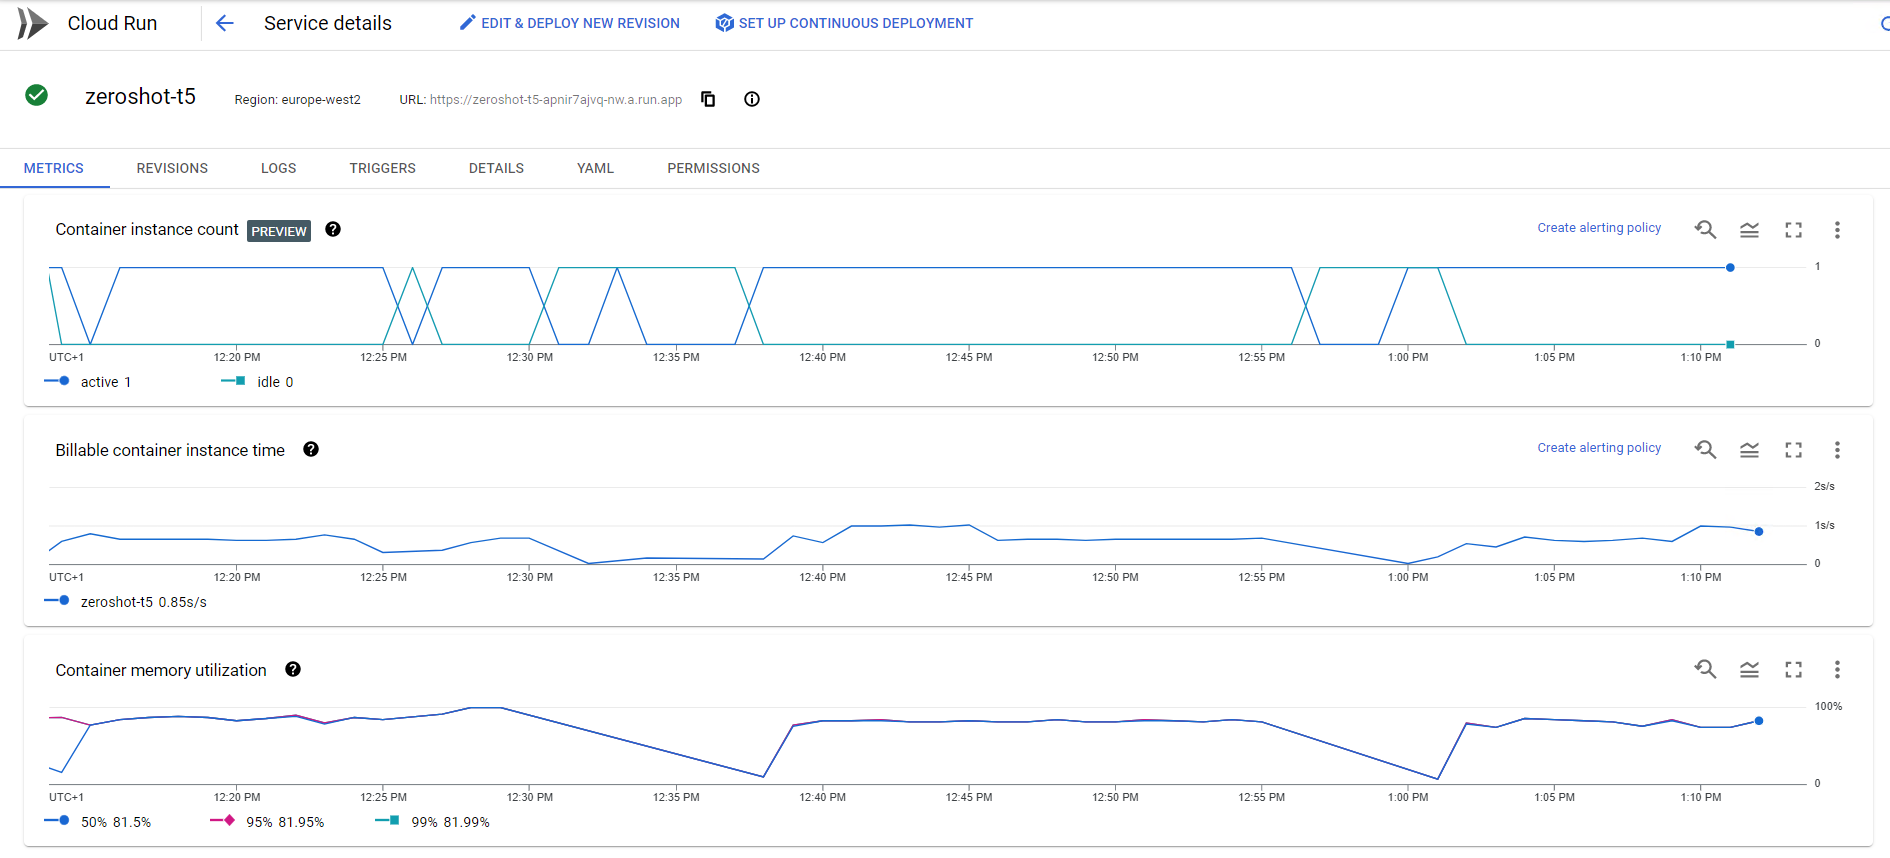

Entry point:
```
gunicorn -b :$PORT -w 2 app:app --timeout 1200
```

In [71]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
upstream connect error or disconnect/reset before headers. reset reason: connection termination
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 2
upstream connect error or disconnect/reset before headers. reset reason: connection termination
upstream connect error or disconnect/reset before headers. reset reason: connection termination
num_threads is: 2; tot number of requests processed in 20s are 2
upstream connect error or disconnect/reset before headers. reset reason: connection terminationupstream connect error or disconnect/reset before headers. reset reason: connection termination

upstream connect error or disconnect/reset before headers. reset reason: connection termination
num_threads is: 3; tot number of requests processed in 20s are 3
up

2021-05-04 13:29:59.012 BSTMemory limit of 5188M exceeded with 5406M used. Consider increasing the memory limit, see https://cloud.google.com/run/docs/configuring/memory-limits

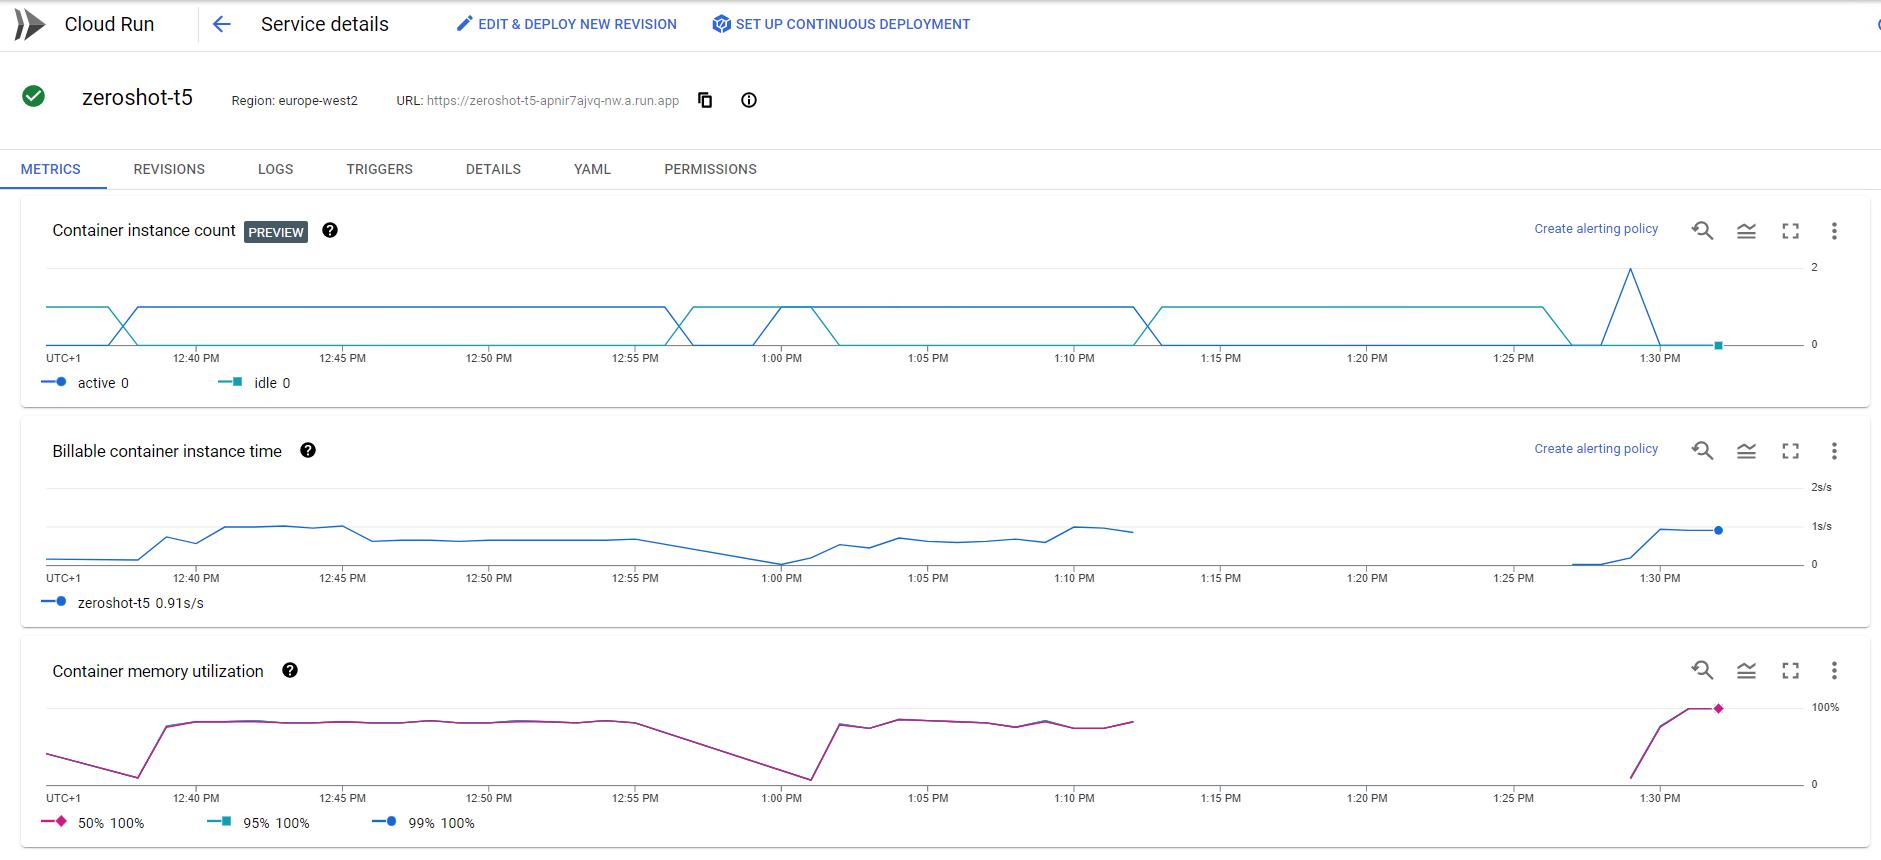

### Experiment 3

1 instance

Host Config:

```
cpu: 4
memory gb: 8
min instance: 0
max instance: 100
```

Entry point:
```
gunicorn -b :$PORT -w 1 app:app --timeout 1200
```

In [77]:
gcr_t5_base = 'https://zeroshot-t5-apnir7ajvq-nw.a.run.app/run-zerohot-t5'
sentence = '''
summarize: The US has passed the peak on new coronavirus cases, 
President Donald Trump said and predicted that some states would reopen this month. 
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, 
the highest for any country in the world. At the daily White House coronavirus briefing on Wednesday, 
Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. 
We will be the comeback kids, all of us, he said. We want to get our country back. 
The Trump administration has previously fixed May 1 as a possible date to reopen the worlds largest economy, 
but the president said some states may be able to return to normalcy earlier than that.
'''
data_t5_base = {
  "sentence": sentence,
    "model_name": "t5-base"
  }

In [78]:
output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
access_token = "Bearer " + output[:-1]
headers = {'Authorization': access_token}
response = requests.post(gcr_t5_base, 
                         headers=headers, 
                         json=data_t5_base)
print(response.text)

{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}


In [79]:
import datetime
import time

tot_pred_time = datetime.timedelta(0)
execution_time = []

for i in range(10):
    print('Epoch: ', i)
    time_start = datetime.datetime.now()
    output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
    access_token = "Bearer " + output[:-1]
    headers = {'Authorization': access_token}
    response = requests.post(gcr_t5_base, 
                             headers=headers, 
                             json=data_t5_base)
    print(response.text)
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print("the time for making the API call is ", time_diff)
    tot_pred_time += time_diff
    execution_time.append(time_diff)
    time.sleep(10)
    
print("the average time for making an API call is ", tot_pred_time/10)

Epoch:  0
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:17.051079
Epoch:  1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:20.353717
Epoch:  2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:20.313020
Epoch:  3
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:16.379411
Epoch:  4
{ output:<pad> the US has over 637

In [80]:
# Latency
import numpy as np
print(np.min(execution_time))
print(np.mean(execution_time))
print(np.max(execution_time))

0:00:16.347803
0:00:18.885271
0:00:24.131076


In [81]:
import time
import os                                                                       
import threading

def num_of_requests_processed_within_a_period(secs):
    num = 0
    stop_time = time.time() + secs
    while time.time() < stop_time:
        output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
        access_token = "Bearer " + output[:-1]
        headers = {'Authorization': access_token}
        response = requests.post(gcr_t5_base, 
                                 headers=headers, 
                                 json=data_t5_base)
        print(response.text)
        num += 1
    return num

In [82]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}



Entry point:
```
gunicorn -b :$PORT -w 2 app:app --timeout 1200
```

In [83]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 2; tot number of requests processed in 20s are 2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new g

### Experiment 4

1 instance

Host Config:

```
cpu: 4
memory gb: 4
min instance: 0
max instance: 100
```

Entry point:
```
gunicorn -b :$PORT -w 1 app:app --timeout 1200
```

In [84]:
gcr_t5_base = 'https://zeroshot-t5-apnir7ajvq-nw.a.run.app/run-zerohot-t5'
sentence = '''
summarize: The US has passed the peak on new coronavirus cases, 
President Donald Trump said and predicted that some states would reopen this month. 
The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, 
the highest for any country in the world. At the daily White House coronavirus briefing on Wednesday, 
Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. 
We will be the comeback kids, all of us, he said. We want to get our country back. 
The Trump administration has previously fixed May 1 as a possible date to reopen the worlds largest economy, 
but the president said some states may be able to return to normalcy earlier than that.
'''
data_t5_base = {
  "sentence": sentence,
    "model_name": "t5-base"
  }

In [90]:
output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
access_token = "Bearer " + output[:-1]
headers = {'Authorization': access_token}
response = requests.post(gcr_t5_base, 
                         headers=headers, 
                         json=data_t5_base)
print(response.text)

{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}


In [86]:
import datetime
import time

tot_pred_time = datetime.timedelta(0)
execution_time = []

for i in range(10):
    print('Epoch: ', i)
    time_start = datetime.datetime.now()
    output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
    access_token = "Bearer " + output[:-1]
    headers = {'Authorization': access_token}
    response = requests.post(gcr_t5_base, 
                             headers=headers, 
                             json=data_t5_base)
    print(response.text)
    time_end = datetime.datetime.now()
    time_diff = time_end - time_start
    print("the time for making the API call is ", time_diff)
    tot_pred_time += time_diff
    execution_time.append(time_diff)
    time.sleep(10)
    
print("the average time for making an API call is ", tot_pred_time/10)

Epoch:  0
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:24.420578
Epoch:  1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:18.225117
Epoch:  2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:24.594528
Epoch:  3
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
the time for making the API call is  0:00:16.682923
Epoch:  4
{ output:<pad> the US has over 637

In [87]:
# Latency
import numpy as np
print(np.min(execution_time))
print(np.mean(execution_time))
print(np.max(execution_time))

0:00:16.682923
0:00:20.188508
0:00:24.594528


In [88]:
import time
import os                                                                       
import threading

def num_of_requests_processed_within_a_period(secs):
    num = 0
    stop_time = time.time() + secs
    while time.time() < stop_time:
        output = subprocess.check_output("gcloud auth print-identity-token", shell=True, text=True)
        access_token = "Bearer " + output[:-1]
        headers = {'Authorization': access_token}
        response = requests.post(gcr_t5_base, 
                                 headers=headers, 
                                 json=data_t5_base)
        print(response.text)
        if 'Service Unavailable' not in str(response.text):
            num += 1
    return num

In [89]:
import concurrent.futures
ls_num_threads = list(range(1, 5))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 1
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 2; tot number of requests processed in 20s are 2
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new g

Entry point:
```
gunicorn -b :$PORT -w 2 app:app --timeout 1200
```

In [91]:
import concurrent.futures
ls_num_threads = list(range(1, 20, 2))
tot_num_requests_processed = []
num_secs = 20
print('The throughput is tested within a duration of {}s'.format(str(num_secs)))

for num_threads in ls_num_threads:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(num_of_requests_processed_within_a_period, num_secs) for param in [num_secs]*num_threads]
        results = [f.result() for f in futures]
        tot_req = sum(results)
        tot_num_requests_processed.append(tot_req)
        print('num_threads is: {};'.format(str(num_threads)), 
              'tot number of requests processed in {}s are {}'.format(str(num_secs), 
                                                                      str(tot_req)))

The throughput is tested within a duration of 20s
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
{ output:<pad> the US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths. the president said new guidelines to reopen the country would be announced on tuesday.
}
num_threads is: 1; tot number of requests processed in 20s are 2
upstream connect error or disconnect/reset before headers. reset reason: connection termination
upstream connect error or disconnect/reset before headers. reset reason: connection termination
upstream connect error or disconnect/reset before headers. reset reason: connection termination
upstream connect error or disconnect/reset before headers. reset reason: connection termination
upstream connect error or disconnect/reset before headers. reset reason: connection terminationupstream connect error or disconnect/reset before he

2021-05-04 15:23:04.749 BSTMemory limit of 4096M exceeded with 4388M used. Consider increasing the memory limit, see https://cloud.google.com/run/docs/configuring/memory-limits

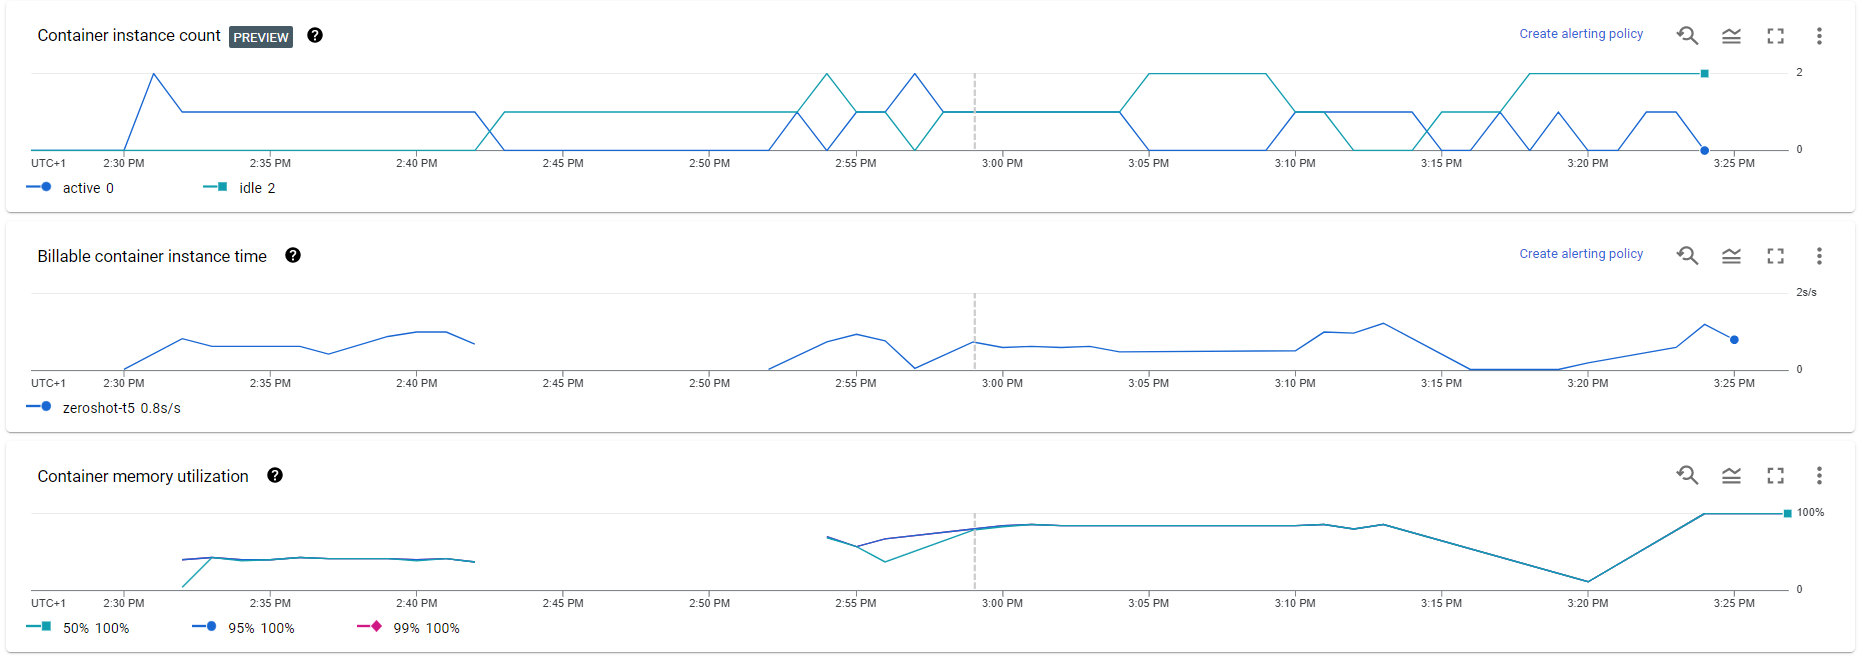